In [1]:
from astropy.io import ascii
import astropy.coordinates as coord
import astropy.units as u
import numpy as np
import matplotlib.pyplot as plt
from astropy.coordinates import EarthLocation, Angle
from astropy.time import Time
from astropy.table import Table, unique

In [2]:
# Set up times and locations

# Birr
birr_loc = EarthLocation(lat=53.095*u.deg, lon=-7.922*u.deg)
observing_time_start_birr = Time('2024-06-25 07:00:00', scale='utc', location=birr_loc)
observing_time_end_birr = Time('2024-06-26 14:00:00', scale='utc', location=birr_loc)
LST_start_birr = observing_time_start_birr.sidereal_time('mean')
LST_end_birr = observing_time_end_birr.sidereal_time('mean')

# Onsala
onsala_loc = EarthLocation(lat=57.399*u.deg, lon=11.930*u.deg)
observing_time_start_onsala = Time('2024-06-25 07:00:00', scale='utc', location=onsala_loc)
observing_time_end_onsala = Time('2024-06-26 14:00:00', scale='utc', location=onsala_loc)
LST_start_onsala = observing_time_start_onsala.sidereal_time('mean')
LST_end_onsala = observing_time_end_onsala.sidereal_time('mean')

# Midpoint
mid_lon = (birr_loc.lon + onsala_loc.lon)/2
mid_loc = EarthLocation(lat=57.399*u.deg, lon=mid_lon)
observing_time_start_mid = Time('2024-06-25 07:00:00', scale='utc', location=mid_loc)
observing_time_end_mid = Time('2024-06-26 14:00:00', scale='utc', location=mid_loc)
LST_start_mid = observing_time_start_mid.sidereal_time('mean')
LST_end_mid = observing_time_end_mid.sidereal_time('mean')

print('Starting LST in Birr:', LST_start_birr)
print('Starting LST in Onsala:', LST_start_onsala)
print('Starting LST at midpoint:', LST_start_mid)

print('\n')

print('Ending LST in Birr:', LST_end_birr)
print('Ending LST in Onsala:', LST_end_onsala)
print('Ending LST at midpoint:', LST_end_mid)

Starting LST in Birr: 0h43m58.08020632s
Starting LST in Onsala: 2h03m22.56020631s
Starting LST at midpoint: 1h23m40.32020631s


Ending LST in Birr: 7h49m03.63149321s
Ending LST in Onsala: 9h08m28.1114932s
Ending LST at midpoint: 8h28m45.8714932s


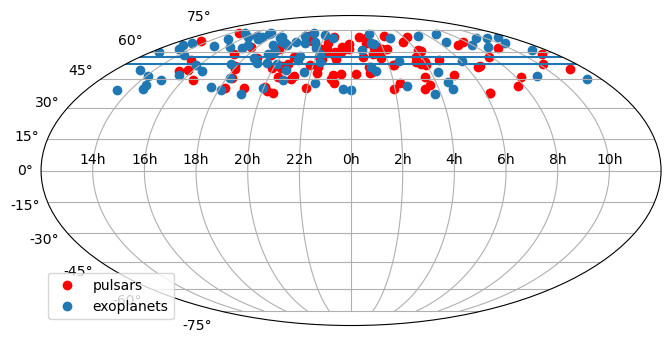

In [3]:
# import data and clean it up

# Exoplanet data
data = ascii.read('PS_2024.06.18_01.13.11.csv')
data.keep_columns(['hostname', 'ra', 'rastr', 'dec', 'decstr', 'sy_dist'])

# One planet per host
data = unique(data, 'hostname')

# Sort by distance
data.sort(keys='sy_dist')

# start and stop observing 40 minutes before/after zenith
start_obs = data['ra'] - 10
stop_obs = data['ra'] + 10

data['start_obs'] = start_obs
data['stop_obs'] = stop_obs

# Sky coordinates of the targets
coords = coord.SkyCoord(ra=data['ra']*u.deg, dec=data['dec']*u.deg)

# Get pulsar data
pulsars = ascii.read('pulsars.csv')
pulsars.remove_column('NUMBER')

# Remove rows without luminosities
ind = pulsars['R_LUM'] != '*'
pulsars = pulsars[ind]

# Convert luminosities to floats
luminosities = np.array([])

for i in range(len(pulsars['R_LUM'])):
    base, exp = pulsars['R_LUM'][i].split('E')
    lum = float(base) * 10**float(exp)
    luminosities = np.append(luminosities, lum)

pulsars['R_LUM'] = luminosities

# Best to observe within 40 minutes of zenith
start_obs_psr = Angle(pulsars['RAJ'], u.hourangle).degree - 10

pulsars['start_obs'] = start_obs_psr

coords_psr = coord.SkyCoord(ra=pulsars['RAJ'], dec=pulsars['DECJ'], unit=(u.hourangle, u.deg))

# Plot them
ra = coord.Angle(data['ra']*u.degree)
ra = ra.wrap_at(180*u.degree)
dec = coord.Angle(data['dec']*u.degree)

ra_psr = coords_psr.ra
ra_psr_wrapped = ra_psr.wrap_at(180*u.degree)
dec_psr = coords_psr.dec

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection="mollweide")
ax.scatter(ra_psr_wrapped.radian, dec_psr.radian, label='pulsars', color='red')
ax.scatter(ra.radian, dec.radian, label='exoplanets')
ax.set_xticklabels(['14h','16h','18h','20h','22h','0h','2h','4h','6h','8h','10h'])
ax.grid(True)
ax.legend()
ax.hlines(53*np.pi/180, -np.pi, np.pi)
ax.hlines(57*np.pi/180, -np.pi, np.pi)

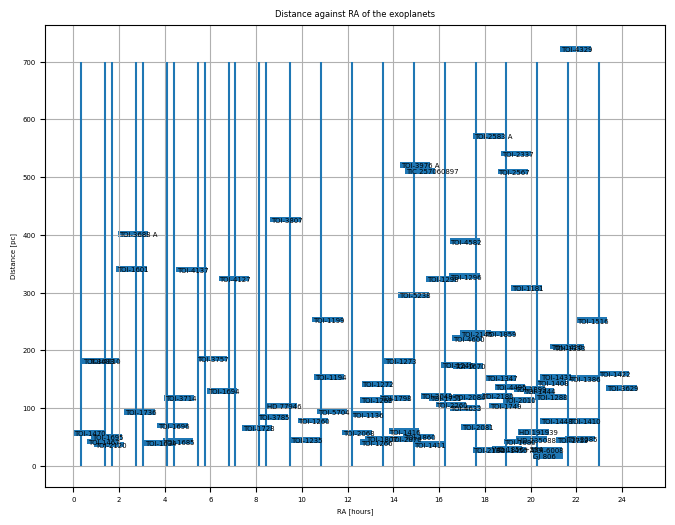

In [4]:
plt.rcParams.update({'font.size': 5})

fig, ax = plt.subplots(figsize=(8,6))

for i in range(len(start_obs)):
    # Plot from start time of observation to +20 degrees (1 hr 20 mins)
    ax.broken_barh([(start_obs[i], 20)], (data['sy_dist'][i], 10))
    ax.text(start_obs[i]+0.5, data['sy_dist'][i], data['hostname'][i])

ax.set_xticks(np.arange(0, 361, 30))
ax.set_xticklabels(np.arange(0, 25, 2))
ax.grid(True)
ax.set_xlabel('RA [hours]')
ax.set_ylabel('Distance [pc]')
ax.set_title('Distance against RA of the exoplanets')


observing_times = np.array([])

for i in range(24):
    observing_times = np.append(observing_times, ((LST_start_mid.value + (81/60)*i) *15) % 360)

ax.vlines(observing_times, 0, 700)


Text(0.5, 1.0, 'Luminosity at 400 MHz (L) against RA of the pulsars')

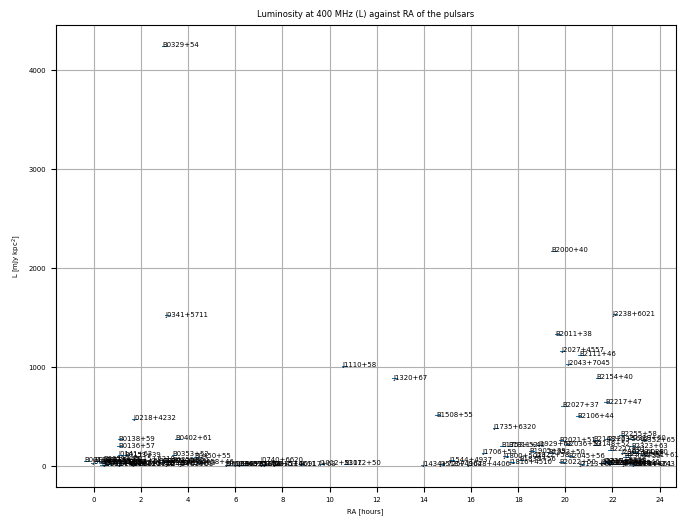

In [5]:
fig, ax = plt.subplots(figsize=(8,6))

for i in range(len(start_obs_psr)):
    # Plot from start time of observation to +3.75 degrees (15 mins)
    ax.broken_barh([(start_obs_psr[i], 3.75)], (pulsars['R_LUM'][i], 10))
    ax.text(start_obs_psr[i]+0.5, pulsars['R_LUM'][i], pulsars['NAME'][i])

ax.set_xticks(np.arange(0, 361, 30))
ax.set_xticklabels(np.arange(0, 25, 2))
ax.grid(True)
ax.set_xlabel('RA [hours]')
ax.set_ylabel('L [mJy kpc$^2$]')
ax.set_title('Luminosity at 400 MHz (L) against RA of the pulsars')

['TOI-2120', 'TOI-1634', 'TOI-1685', 'TOI-1694', 'TOI-1728', 'TOI-3785', 'TOI-1235', 'TOI-5704', 'TOI-1266', 'TOI-2076', 'TOI-1411', 'TOI-4633', 'TOI-2134', 'TOI-1450 A', 'GJ 806', 'TOI-1759', 'TOI-3629', 'TOI-1467', 'TOI-1736', 'TOI-1696', 'TOI-3714', 'TOI-3757']


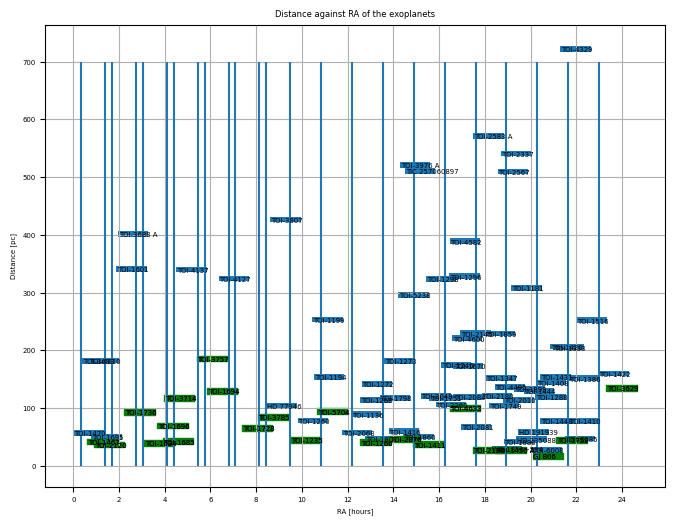

In [6]:
data = unique(data, 'hostname')
data.sort(keys='sy_dist')

data_test = Table(data, copy=True)

time = LST_start_mid.value
time_offset = 0
time_offset_tracking = 0
number_deleted = 0
target_list = []

# Go for 31 hours
while time_offset_tracking <= 31:
    # Check for all stars
    for i in range(len(data_test['ra']) - number_deleted):

        # Check if the planet reaches zenith between the start and end of the observation window
        if (time + time_offset) * 15 >= 360:
            time_offset -= 24
        if ((time + time_offset) * 15) <= data_test['ra'][i] and data_test['ra'][i] <= ((time + time_offset + 81/60) * 15): 

            # Add to list of targets
            target_list.append(data_test['hostname'][i])
            # Remove target from the list 
            data_test.remove_row(i)


            # Keep track of how many deleted to prevent going out of bounds
            number_deleted += 1
            break
        
    # Move on 1 hr 21 mins (allow 1 minute to point)
    time_offset += 81/60
    time_offset_tracking += 81/60


print(target_list)

# Plot the optimum viewing windows for the targets
fig, ax = plt.subplots(figsize=(8,6))
        
for i in range(len(data['ra'])):
    # Plot from start time of observation to +20 degrees (1 hr 20 mins)
    ax.broken_barh([(data['ra'][i] - 10, 20)], (data['sy_dist'][i], 10))
    ax.text(data['ra'][i]+0.5 - 10, data['sy_dist'][i], data['hostname'][i])


for i in range(len(target_list)):
    # Plot from start time of observation to +20 degrees (1 hr 20 mins)

    index = data['hostname'] == target_list[i]
    ind = np.argwhere(index)[0][0]

    # Plot from start time of observation to +20 degrees (1 hr 20 mins)
    ax.broken_barh([(data['ra'][ind] - 10, 20)], (data['sy_dist'][ind], 10), color='green')
    ax.text(data['ra'][ind]+0.5 - 10, data['sy_dist'][ind], data['hostname'][ind])

ax.set_xticks(np.arange(0, 361, 30))
ax.set_xticklabels(np.arange(0, 25, 2))
ax.grid(True)
ax.set_xlabel('RA [hours]')
ax.set_ylabel('Distance [pc]')
ax.set_title('Distance against RA of the exoplanets')


observing_times = np.array([])

for i in range(24):
    observing_times = np.append(observing_times, ((LST_start_mid.value + (81/60)*i) *15) % 360)

ax.vlines(observing_times, 0, 700)



In [7]:
# Output schedule with pointings

sched = Table(names=('target', 'ra', 'dec'), dtype=(str, float, float))

for i in range(len(target_list)):
    index = data['hostname'] == target_list[i]
    ind = np.argwhere(index)[0][0]

    sched.add_row((data['hostname'][ind], data['ra'][ind], data['dec'][ind]))

# Get UTC times
start_times = np.array([])
end_times = np.array([])

time = observing_time_start_mid.mjd
time_end = observing_time_end_mid.mjd

while time + (1*u.hr + 21*u.min).to(u.day).value <= time_end:
    start_times = np.append(start_times, time)
    time += (1*u.hr + 21*u.min).to(u.day).value
    end_times = np.append(end_times, time - (1*u.min).to(u.day).value)

sched['start_utc'] = Time(start_times, format='mjd').iso
sched['end_utc'] = Time(end_times, format='mjd').iso


In [8]:
sched

target,ra,dec,start_utc,end_utc
str10,float64,float64,str23,str23
TOI-2120,23.507315,65.5139877,2024-06-25 07:00:00.000,2024-06-25 08:20:00.000
TOI-1634,56.3906096,37.1122803,2024-06-25 08:21:00.000,2024-06-25 09:41:00.000
TOI-1685,68.5939529,43.0370395,2024-06-25 09:42:00.000,2024-06-25 11:02:00.000
TOI-1694,97.7487104,66.3605956,2024-06-25 11:03:00.000,2024-06-25 12:23:00.000
TOI-1728,120.6116787,64.7971531,2024-06-25 12:24:00.000,2024-06-25 13:44:00.000
TOI-3785,130.9002258,63.0780768,2024-06-25 13:45:00.000,2024-06-25 15:05:00.000
TOI-1235,152.2182549,69.2766204,2024-06-25 15:06:00.000,2024-06-25 16:26:00.000
TOI-5704,169.8248694,44.9890782,2024-06-25 16:27:00.000,2024-06-25 17:47:00.000
TOI-1266,197.9965833,65.8336973,2024-06-25 17:48:00.000,2024-06-25 19:08:00.000


Text(0, 0.5, 'dec [deg]')

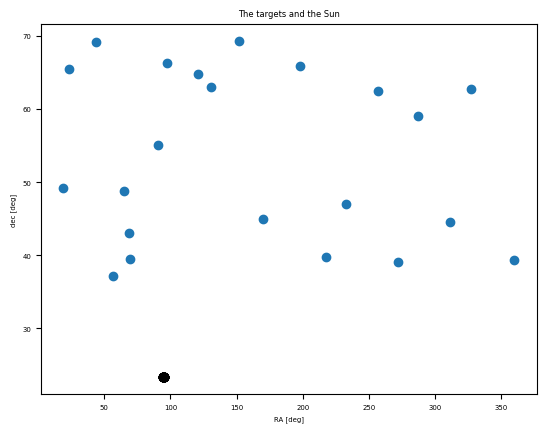

In [9]:
middle_times = (start_times + end_times)/2

sun_times = Time(middle_times, format='mjd')

sun_loc = coord.get_sun(sun_times)

sun_ra = sun_loc.ra
sun_dec = sun_loc.dec

plt.scatter(sun_ra, sun_dec, color='black')
plt.scatter(sched['ra'], sched['dec'])
plt.title('The targets and the Sun')
plt.xlabel('RA [deg]')
plt.ylabel('dec [deg]')

In [10]:
dist_to_sun = np.array([])

for i in range(len(sched['ra'])):
    dist_to_sun = np.append(dist_to_sun, np.sqrt((sun_ra[i].value - sched['ra'][i])**2 + (sun_dec[i].value - sched['dec'][i])**2))

sched['angle_sun'] = dist_to_sun

In [11]:
sched

target,ra,dec,start_utc,end_utc,angle_sun
str10,float64,float64,str23,str23,float64
TOI-2120,23.507315,65.5139877,2024-06-25 07:00:00.000,2024-06-25 08:20:00.000,82.34322381577981
TOI-1634,56.3906096,37.1122803,2024-06-25 08:21:00.000,2024-06-25 09:41:00.000,40.33205157180333
TOI-1685,68.5939529,43.0370395,2024-06-25 09:42:00.000,2024-06-25 11:02:00.000,32.419133564880035
TOI-1694,97.7487104,66.3605956,2024-06-25 11:03:00.000,2024-06-25 12:23:00.000,43.11510030771856
TOI-1728,120.6116787,64.7971531,2024-06-25 12:24:00.000,2024-06-25 13:44:00.000,48.97506629138917
TOI-3785,130.9002258,63.0780768,2024-06-25 13:45:00.000,2024-06-25 15:05:00.000,53.83674720709258
TOI-1235,152.2182549,69.2766204,2024-06-25 15:06:00.000,2024-06-25 16:26:00.000,73.66811518451314
TOI-5704,169.8248694,44.9890782,2024-06-25 16:27:00.000,2024-06-25 17:47:00.000,78.21102242401079
TOI-1266,197.9965833,65.8336973,2024-06-25 17:48:00.000,2024-06-25 19:08:00.000,111.66707498641496
